# Mask RCNN and U-Net for Instance Segmentation
U-Net as Backbone

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/Users/imkeschwenke/Programmieren/InstanceSegmentation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# root directory of the project
ROOT_DIR = './'

import mrcnn.utils
import mrcnn.visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import CElegansDataset


COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_coco.h5")

In [3]:
from cElegans import CElegansConfig
config = CElegansConfig()
CELEGANS_DIR = os.path.join(ROOT_DIR, "dataset")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       unet
BACKBONE_STAGE5                False
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE       

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
from cElegans import CElegansDataset

# Load Training dataset
dataset = CElegansDataset()
dataset.load_c_elegans(CELEGANS_DIR, "train")
dataset.prepare()

datatset_val = CElegansDataset()
datatset_val.load_c_elegans(CELEGANS_DIR, "val")
datatset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 214
Classes: ['BG', 'c_elegans']


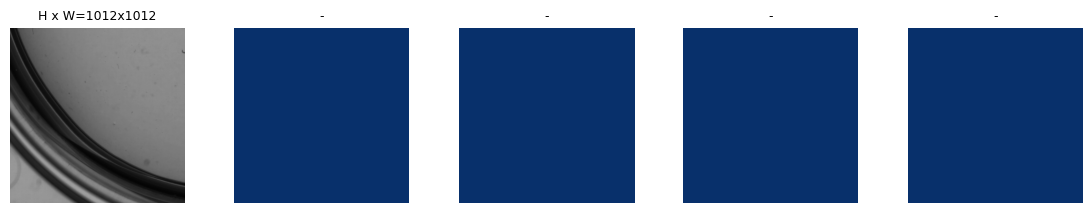

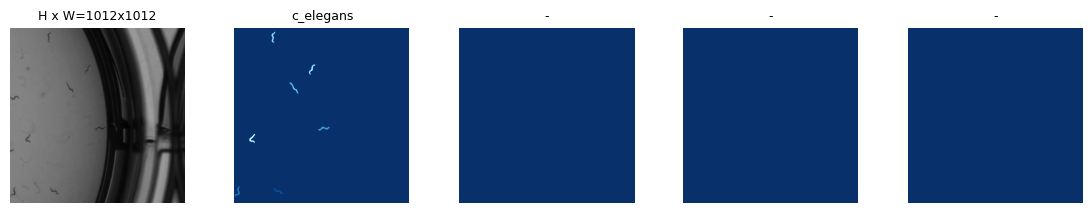

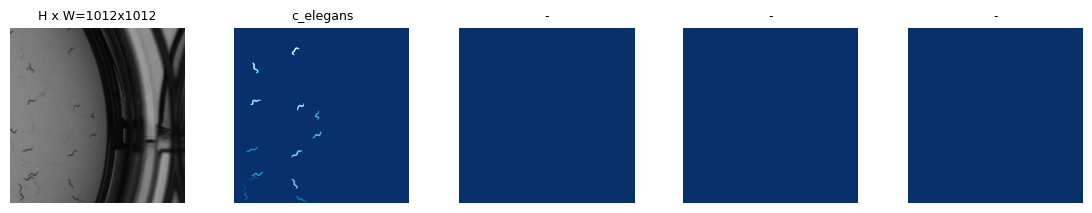

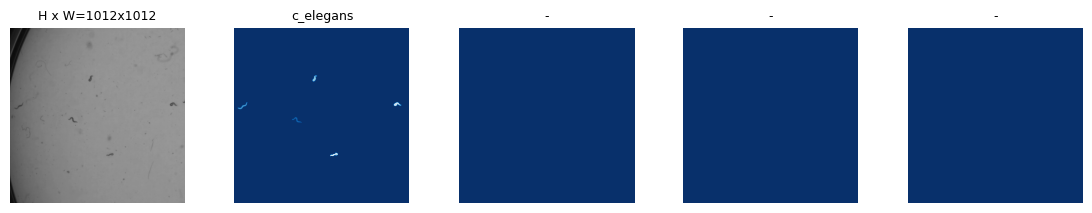

In [8]:
from mrcnn import visualize
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [9]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

P5 shape: (None, None, None, 256)
C4 shape: (None, None, None, 512)
P5 shape: (None, None, None, 256)
C4 shape: (None, None, None, 512)


In [10]:

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask",
                            "fpn_c5p5", "fpn_c4p4", "fpn_c3p3", "fpn_c2p2"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
     

2024-09-10 15:22:12.649554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-09-10 15:22:12.656796: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'proposal_targets/cond/output/_16'


In [12]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset, datatset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/c_elegans20240910T1522/mask_rcnn_c_elegans_{epoch:04d}.h5
Selecting layers to train
fpn_c4p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3_reduced         (Conv2D)
fpn_c2_reduced         (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistrib

/Users/imkeschwenke/Programmieren/InstanceSegmentation/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-09-10 15:23:23.111523: W tensorflow/c/c_api.cc:304] Operation '{name:'range_10' id:6494 op device:{requested: '', assigned: ''} def:{{{node range_10}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range_10/start, Rank_10, range_10/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-10 15:23:23.326768: W tensorflow/c/c_api.cc:304] Operation '{name:'range_11' id:6504 op device:{requested: '', assigned: ''} def:{{{node range_11}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range_11/start, Rank_11, range_11/delta)}}' was changed by

InvalidArgumentError: Incompatible shapes: [1,256,256,256] vs. [1,128,128,256]
	 [[{{node training_2/SGD/gradients/gradients/fpn_p4add/add_grad/BroadcastGradientArgs}}]]